In [35]:
import eli5
from eli5.sklearn import PermutationImportance
from math import ceil, sqrt as root
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, OneHotEncoder
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNetCV, LassoCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')


# Exploratory Data Analysis

### We start by loading and viewing the data available to us.

In [2]:
train_set = pd.read_csv("train.csv")
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_set = pd.read_csv("test.csv")
test_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### The train set consists of 1460 rows and 81 features while the test set consists of 1459 rows and 80 features. What feature is missing in the test set?

In [4]:
set(train_set.columns) - set(test_set.columns)

{'SalePrice'}

In [5]:
sample = pd.read_csv("sample_submission.csv")

#### Apparently, the `SalePrice` for the test_set is what we are to predict.

#### How about we take a closer look into the type of prices available in the dataset?

In [6]:
train_set["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'SalePrice distribution')

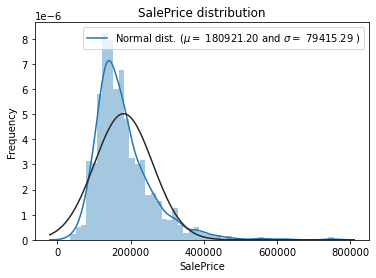

In [7]:
# Let's take a look at the distribution of the SalePrice 
sns.distplot(train_set['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train_set['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#### Looks like the price is left skewed so we work with the log of the prices.

Text(0.5, 1.0, 'SalePrice distribution')

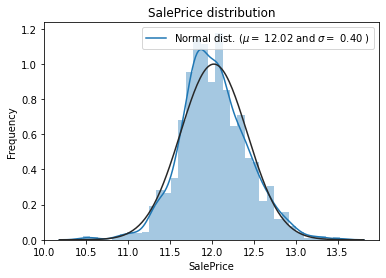

In [8]:
price = np.log1p(train_set["SalePrice"])
 
sns.distplot(price , fit=norm);
(mu, sigma) = norm.fit(price)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#### Now that looks more like it...

#### What year did we have the most sales?

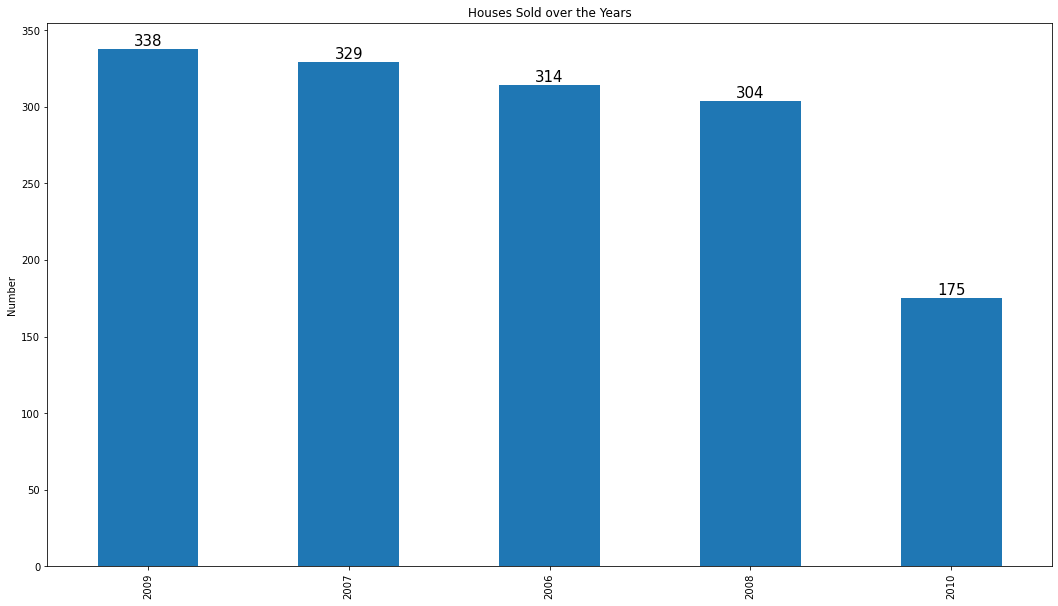

In [9]:
plt.figure(figsize=(18,10))
plots = train_set["YrSold"].value_counts().plot(kind="bar")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Houses Sold over the Years")
plt.ylabel("Number")
plt.show()

#### Looks like we had more house sales in 2009 and the least sales in 2010.
#### What type of sale was the most purchased?

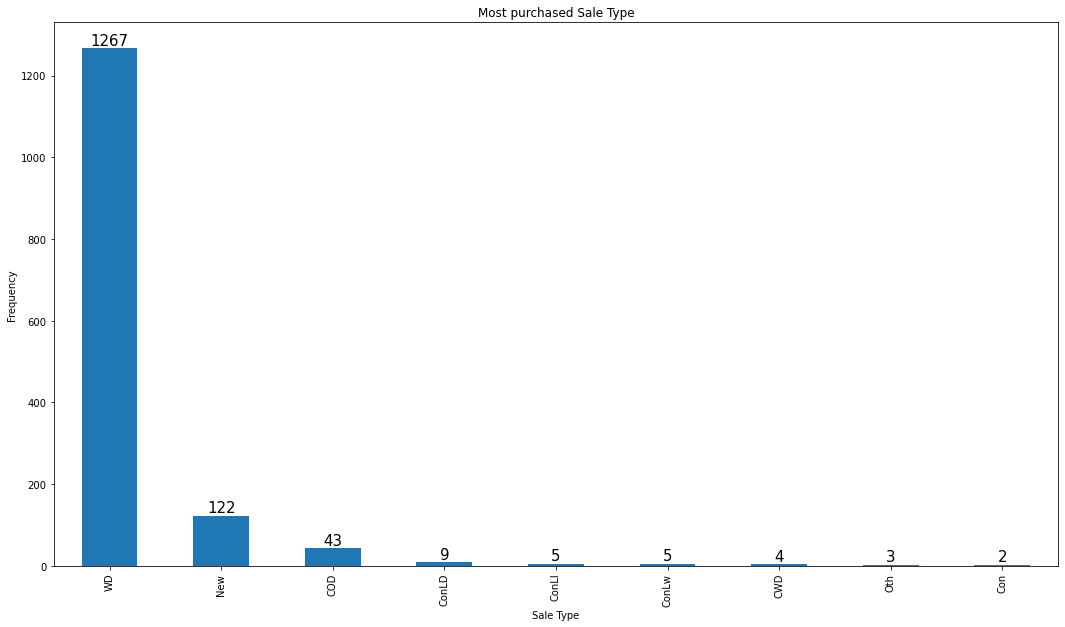

In [10]:
plt.figure(figsize=(18,10))
plots = train_set["SaleType"].value_counts().plot(kind="bar")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Most purchased Sale Type")
plt.ylabel("Frequency")
plt.xlabel("Sale Type")
plt.show()

#### How about another look at the data

In [11]:
train_set.groupby(["YrSold", "MoSold"]).count()

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
YrSold MoSold                                                                  
2006   1       10          10        10            7       10      10      1   
       2        9           9         9            7        9       9      0   
       3       25          25        25           22       25      25      1   
       4       27          27        27           23       27      27      6   
       5       38          38        38           31       38      38      2   
       6       48          48        48           40       48      48      3   
       7       67          67        67           59       67      67      2   
       8       23          23        23           20       23      23      2   
       9       15          15        15           15       15      15      1   
       10      24          24        24           22       24      24      1   
       11      16          16        16           11       16      16      0   
       12      12          12        12            8       12      12      0   
2007   1       13          13        13           12       13      13      0   
       2        8           8         8            7        8       8      0   
       3       23          23        23           15       23      23      1   
       4       23          23        23           20       23      23      1   
       5       43          43        43           34       43      43      1   
       6       59          59        59           43       59      59      5   
       7       51          51        51           43       51      51      3   
       8       40          40        40           32       40      40      4   
       9       11          11        11           10       11      11      1   
       10      16          16        16           12       16      16      1   
       11      24          24        24           21       24      24      2   
       12      18          18        18           17       18      18      0   
2008   1       13          13        13           12       13      13      0   
       2       10          10        10           10       10      10      1   
       3       18          18        18           13       18      18      4   
       4       26          26        26           22       26      26      4   
       5       38          38        38           29       38      38      1   
       6       51          51        51           41       51      51      9   
       7       49          49        49           39       49      49      3   
       8       29          29        29           27       29      29      2   
       9       17          17        17           14       17      17      1   
       10      22          22        22           19       22      22      0   
       11      17          17        17           15       17      17      1   
       12      14          14        14           13       14      14      1   
2009   1       12          12        12            9       12      12      1   
       2       10          10        10            8       10      10      1   
       3       19          19        19           15       19      19      1   
       4       26          26        26           22       26      26      1   
       5       37          37        37           30       37      37      2   
       6       59          59        59           45       59      59      3   
       7       61          61        61           54       61      61      4   
       8       30          30        30           24       30      30      3   
       9       20          20        20           18       20      20      1   
       10      27          27        27           23       27      27      1   
       11      22          22        22           16       22      22      1   
       12      15          15        15            9       15      15      1   
2010   1       

#### Well, a closer look at the charts and data just shows that nothing spectacular happened in 2009. The number of purchases increase by the year and it is safe to say that the data available to us at the moment does not have complete records for the whole year 2010, only records up to the month of July in 2010 are available.

## Data Cleaning

#### Let's look into the data to see the features that have empty values

In [12]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

`Alley`, `PoolQC`, `Fence`, `MiscFeature` have the highest number of NaN values, we can fill this for EDA as nan means that feature is unavailable for the apartment. Other columns can be filled with their means if numerical and modes if categorical. However, I'll drop `MiscFeature`.

#### Created a function that replaces nan values in each categorical column as the mode of the values in that column and replace nan values in numerical values with the median of the columns.

In [13]:
def clean_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    df = dataframe.copy()
    df.drop("Id", axis=1)
    # Replace columns where nan means they don't have these features with "None".
    unavailable = ["Alley", "PoolQC", "Fence", "GarageType", "GarageFinish", "GarageQual", 
                   "GarageCond", "FireplaceQu", "Electrical", "BsmtQual", "BsmtCond", 
                   "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType", "MiscFeature"]

    for col in unavailable:
        df[col].fillna('Unavailable',inplace=True)
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype == 'O':
            df[column] = df[column].fillna(df[column].mode()[0])
        if df[column].dtype == 'int' or df[column].dtype == 'float':
            df[column] = df[column].fillna(df[column].median())
    return df
        

In [37]:
clean_df = clean_data(train_set)
clean_df.isnull().sum()[clean_df.isnull().sum() > 0] #check if it still contains null values

Series([], dtype: int64)

In [15]:
# sns.pairplot(data=clean_df, diag_kind='kde')

In [38]:
clean_df['total_square_footage'] = clean_df['TotalBsmtSF'] + clean_df['GrLivArea']
clean_df['total_area_of_house'] = clean_df['TotalBsmtSF'] + clean_df['1stFlrSF'] + clean_df['2ndFlrSF']

#### Of the now 81 columns, 43 are non numerical data. This simply means that we have to do alot of encoding on our current data.

# Feature Engineering

#### In order to determine the features that play important roles in the determination of the sales price, we can start by checking the features that have strong positive or negative correlations with the sales price. 

<AxesSubplot:>

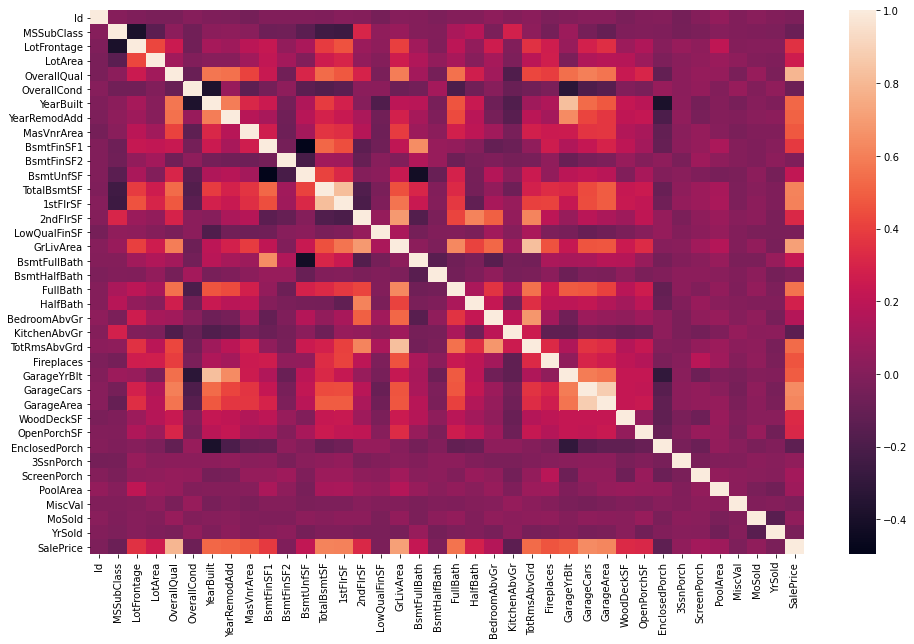

In [17]:
#correlation matrix
corr = train_set.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr)

#### From the above matrix, we can see that `OverallQual` has the highest positive correlation with `SalesPrice` followed closely by `GrLivarea` while `OverallCond`, `KitchenAbvGr`, `EnclosedPorch` have the lowest correlations with `SalesPrice`. This simply means that the features with high correlation can be very useful in predicting prices aand we should pay close attention to them.

In [18]:
date_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

def change_dates(df):
    data = df.copy()    
    for feature in date_features:
        data[feature] = data['YrSold'] - data[feature]
    
    return data

In [39]:
df = change_dates(clean_df.drop("SalePrice", axis=1))
scaler = RobustScaler()
numerical = [
             'LotArea',
             'MasVnrArea',
             'BsmtFinSF1',
             'BsmtFinSF2',
             'BsmtUnfSF',
             'TotalBsmtSF',
             '1stFlrSF',
             '2ndFlrSF',
             'LowQualFinSF',
             'GrLivArea',
             'GarageArea',
             'WoodDeckSF',
             'OpenPorchSF',
             'PoolArea']
df[numerical] = scaler.fit_transform(df[numerical])

## Encoding and Feature Crosses

In [20]:
categories_to_label = ['LotFrontage', 'LotShape',  'LotConfig',
       'Condition1', 'Condition2', 'MasVnrType',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',  
       'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'KitchenAbvGr', 'KitchenQual',
       'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual','GarageCond']

In [21]:
def cross_features(dataframe):
    dataframe["basement_condition"] = (dataframe['BsmtQual'] + dataframe['BsmtCond'] + dataframe['BsmtExposure']
                                    + dataframe['BsmtFinType1'] + dataframe['BsmtFinSF1'] + dataframe['BsmtFinType2']
                                    + dataframe['BsmtFinSF2'] + dataframe['BsmtUnfSF'] + dataframe['TotalBsmtSF']
                                    + dataframe['BsmtFullBath'] + dataframe['BsmtHalfBath'])
    dataframe["garage_condition"] = (dataframe['GarageType'] + dataframe['GarageFinish']
                                    + dataframe['GarageCars'] + dataframe['GarageArea'] + dataframe['GarageQual'] * dataframe['GarageCond']) * dataframe['GarageYrBlt']
    dataframe["kitchen_condition"] = dataframe['KitchenAbvGr'] + dataframe['KitchenQual']
    dataframe["Mas"] = dataframe['MasVnrType'] + dataframe['MasVnrArea']
    dataframe["Lot"] = dataframe['LotFrontage'] + dataframe['LotShape'] + dataframe['LotConfig']
    dataframe["Condition"] = dataframe["Condition1"] + dataframe["Condition2"]
    dataframe["Exterior"] = dataframe["Exterior1st"] + dataframe["Exterior2nd"]
    dataframe["bath"] = (dataframe['BsmtFullBath'] + dataframe['BsmtHalfBath']) * (dataframe['FullBath']+ dataframe['HalfBath'])
    dataframe["temperature"] = dataframe["Heating"] + dataframe["HeatingQC"]
    return dataframe

In [40]:
hot_encoder = OneHotEncoder(handle_unknown="ignore")
hot_encoder.fit(df)
df = hot_encoder.transform(df)
train_data = df.toarray()

In [ ]:
wcss = []
for i in range(1,200):
  kmeans_pca = KMeans(n_clusters=i, random_state=42)
  kmeans_pca.fit(df.toarray())
  wcss.append(kmeans_pca.inertia_)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(1,df.shape[0]), wcss, marker='o', linestyle='--')
plt.title('KMeans with PCA clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

In [31]:
# kmeans = KMeans(n_clusters=100, max_iter=3000)
# train_data = kmeans.fit_transform(df.toarray())


# Modelling

In [24]:
#For cross validation
def rmsle_cv(model):
    kf = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42).get_n_splits(df)

    rmse = np.sqrt(-cross_val_score(
        model,
        df,
        price,
        scoring="neg_mean_squared_error",
        cv = kf)
    )
    return rmse

In [25]:
test_set.isnull().sum()[test_set.isnull().sum() > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [32]:
# Prepare and encode test set
test_set["SaleType"] = test_set["SaleType"].fillna("Oth")
test_df = change_dates(clean_data(test_set))
test_df['total_square_footage'] = test_df['TotalBsmtSF'] + test_df['GrLivArea']
test_df['total_area_of_house'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
test_df[numerical] = scaler.transform(test_df[numerical]) 
# test_df[categories_to_label] = test_df[categories_to_label].apply(oe.transform)
# test_df = cross_features(test_df)
# test_df[skewed_feats] = np.log1p(test_df[skewed_feats])
test_data = hot_encoder.transform(test_df).toarray()
test_data = kmeans.transform(test_data)

## Linear Model

### Linear Regression

In [27]:
selector = SelectFromModel(
    estimator=LinearRegression(),
    threshold='median'
)
selector.fit(train_data, price)

SelectFromModel(estimator=LinearRegression(), threshold='median')

In [33]:
linear_reg = LinearRegression()
linear_reg.fit(train_data, price)

LinearRegression()

In [34]:
rmsle_cv(linear_reg)

array([0.13874058, 0.16062623, 0.15161134, 0.13777818, 0.15880321])

In [30]:
# Predict the test data using the Linear Model.
predicted_linear_reg = linear_reg.predict(selector.transform(test_data))
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_linear_reg)}).head(10)

ValueError: X has 5523 features, but LinearRegression is expecting 11046 features as input.

In [ ]:
print("Mean squared Log Error using Linear Regression on Test Set:", root(mean_squared_log_error(np.log1p(sample["SalePrice"]), predicted_linear_reg)))

### Lasso 

In [ ]:
selector = SelectFromModel(
    estimator=li(),
    threshold='0.5*mean'
)
selector.fit(x_train, y_train)

In [ ]:
# lasso = Lasso(alpha=0.0005, max_iter=3000)
lasso = LassoCV(alphas = [0.0003])
lasso.fit(train_data, price)

In [ ]:
rmsle_cv(lasso)

In [ ]:
# Predict the test data using the Linear Model.
predicted_lasso = lasso.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_lasso)}).head(10)

In [ ]:
print("Mean squared Log Error using Lasso on Test Set:", root(mean_squared_log_error(np.log1p(sample["SalePrice"]), predicted_lasso)))

## Ridge

In [ ]:
ridge = Ridge(alpha=14, solver="auto")
ridge.fit(train_data, price) 

In [ ]:
rmsle_cv(ridge)

In [ ]:
# Predict the test data using the Ridge.
predicted_ridge = ridge.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_ridge)}).head(10)

In [ ]:
print("Mean squared Log Error using Ridge on Test Set:", root(mean_squared_log_error(np.log1p(sample["SalePrice"]), predicted_ridge)))

## Elastic Net

In [ ]:
elastic_net = ElasticNet(random_state=0, alpha=0.0005, max_iter=5000, selection="random")
# elastic_net = ElasticNetCV(cv=5, random_state=0)
elastic_net.fit(train_data, price)

In [ ]:
rmsle_cv(elastic_net)

In [ ]:
# Predict the test data using the Elastic Net.
predicted_elastic = elastic_net.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_elastic)}).head(10)

In [ ]:
print("Mean squared Log Error using Elastic Net on Test Set:", root(mean_squared_log_error(np.log1p(sample["SalePrice"]), predicted_elastic)))

## Random Forest

In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [ ]:
# rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# rf_random.fit(df.toarray(), price)
# rf_random.best_params_

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 1000]
}


In [ ]:
grid = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs=-1) #

# fitting the model for grid search 
grid_result = grid.fit(train_data, price)
best_params = grid_result.regressor_.best_params_
print(best_params)

In [ ]:
## making predictions using the Random Forest algorithm 

bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.852, total= 2.5min

 bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.852, total= 1.4min

forest_model = RandomForestRegressor(n_estimators=1000, random_state=30, n_jobs=-1, oob_score=True)
forest_model.fit(train_data, price)
rmsle_cv(forest_model)

In [ ]:
# Predict the test data using the Random Forest Model.
predicted_rf = forest_model.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_rf)}).head(10)

In [ ]:
print("Mean squared Log Error using Random Forest on Test Set:", root(mean_squared_log_error(np.log1p(sample["SalePrice"]), predicted_rf)))

In [ ]:
# ## Generate stacking
# stack = StackingCVRegressor(regressors=(linear_reg, forest_model), meta_regressor=forest_model, use_features_in_secondary=True)
# stack.fit(df.toarray(), price)
# stack.predict(test_data)

# Submission

In [ ]:
submission = pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_linear_reg)})
submission.to_csv("submission.csv",index = False)
print("predictions successfully submitted")